# 1D Viscoelasticity - Recurrent Neural Networks

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz

Summer term 2024

---

#### In this notebook, you will...

* calibrate different RNN-based models to viscoelastic data in 1D.
* learn how physics can be embedded into RNN-based models for viscoelasticity.
* experience the impact of including physics on the models' interpolation and extrapolation capabilities.


In [1]:
import datetime

import src.data as d
import src.models as m
import src.plots as p

now = datetime.datetime.now

*Run the following two cells to clone the GitHub repository in your current Google Colab environment*

In [ ]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML.git

In [ ]:
import datetime

from LecturePhysicsAwareML.1D_material_modeling.viscoelasticity.src import data as d
from LecturePhysicsAwareML.1D_material_modeling.viscoelasticity.src import models as m
from LecturePhysicsAwareML.1D_material_modeling.viscoelasticity.src import plots as p

now = datetime.datetime.now

*Run the following cell to remove the cloned repository.*

In [ ]:
%rm -rf LecturePhysicsAwareML

## 1. Model theory

In this task we present and implement one analytical and two NN-based models for 1D viscoelasticity. The models make use of so called *recurrent neural networks*, which are available as part of the Tensorflow library. The Maxwell and GSM models are designed to fulfill the *Clausius-Duhem inequality*. Hence, they comply with the second law of thermodynamics and are thermodynamically consistent. The Clausius-Dumen inequality reads

$$
\sigma \dot{\epsilon} - \dot{e} \geq 0
$$

### 1.1 Generalized Maxwell model

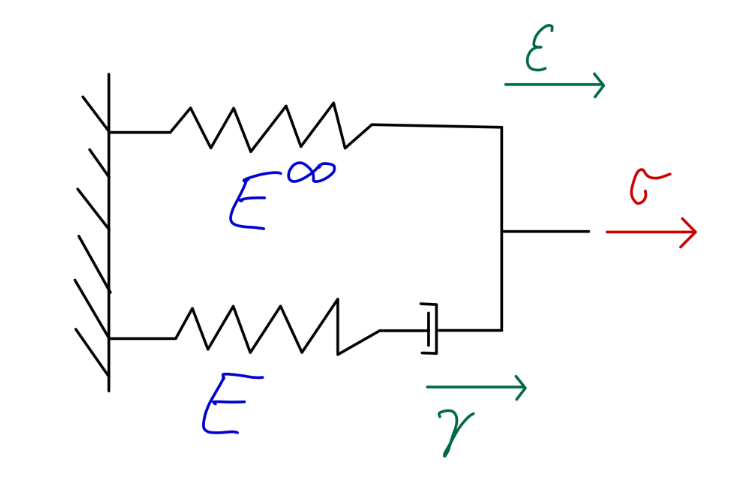

The generalized Maxwell model represents viscoelastic behaviour through a number of spring-damper elements, which are in parallel to an *equilibrium spring* element. For this task we consinder a simple Maxwell element with an *equilibrium spring* with stiffness $E^{\infty} > 0$ in parallel to a series connection of a *non-equilibrium spring* with stiffness $E > 0$ in series with a *damper*. Here, $\epsilon$ denotes the overall strain acting on the system, while the internal variable $\gamma$ denotes the strain acting on the damper. Consequently, the strain $(\epsilon - \gamma)$ acts on the non-equilibrium spring.

Energy is stored in both the equilibrium and the non-equilibrium
spring, leading to the overall energy
$$
e = \frac{1}{2} E^{\infty} \epsilon^2 + \frac{1}{2} E (\epsilon - \gamma).
$$

Similarly, the overall stress is composed of the stresses acting in the equilibrium spring and the spring-damper element, respectively. With $\sigma = \partial e/\partial \epsilon$ the stress follows as
$$
\sigma = E^{\infty} \epsilon + E (\epsilon - \gamma).
$$

To fully describe the consitutive behaviour, an *evolution equation* has to be formulated for the internal variable $\gamma$ in such way that it complies with the Clausius-Duhem inequality. Here we choose

$$
\dot{\gamma} = \frac{E}{\eta}(\epsilon - \gamma),
$$

assuming that the damper behaves like a Newtonian fluid with the viscosity $\eta > 0$. The evolution equation can be derived from the stress equilibrium in the spring-damper element. From the series connection of non-equilibrium spring and damper we conclude that $\sigma^{\text{damper}} = \sigma^{\text{non-equilibrium}}$. With $\sigma^{\text{damper}} = \eta \dot{\gamma}$ it follows

$$
\eta \dot{\gamma} = E (\epsilon - \gamma)
$$

and, thus, the evoluation equation.

**Computation within the RNN cell:**

First we compute the stress for the current time step

$$
\sigma_n = E^{\infty} \epsilon_n + E (\epsilon_n - \gamma_n)
$$

and integrate the internal variable to the next time step using the explicit Euler scheme as

$$
\gamma_{n+1} = \gamma_n + h_n \dot{\gamma}_n = \gamma_n + h_n \frac{E}{\eta}(\epsilon_n - \gamma_n)
$$

Here, $\gamma_n = \gamma(t_n)$, $t_{n+1} = t_n + h_n$ and the initial value $\gamma_0 = 0$.

### 1.2 Naive RNN model

The naive RNN model does not include any prior description of the internal energy and no evoluation equation of the internal variables.

**Computation within the RNN cell:**

Instead, the stress of the current time step $\sigma_n$ and the internal variable of the subsequent time step $\gamma_{n+1}$ are predicted directly by an NN as

$$
\gamma_{n+1}, \sigma_n = NN(\epsilon_n, h_n, \gamma_n).
$$


### 1.3 GSM model

In the third model, the consitutive model is derived from the more general framework of *Generalized Standard Materials* (GSM), representing a more general approach to modeling viscoelasticity. Here, we consider the internal energy in its most general form $e = e(\epsilon, \gamma)$, without making any further assumptions on its functional relationship. Again, the stress is given as $\sigma = \partial e/\partial \epsilon$. 

In addition to the internal energy $e$, we introduce the dissipation potential $\phi = \phi(\epsilon, \gamma, \dot{\gamma})$ as

$$
\phi(\epsilon, \gamma,\dot{\gamma}) = \frac{1}{2 g (\epsilon, \gamma)} \dot{\gamma}^2, \qquad g(\epsilon, \gamma) > 0
$$

and the additonal constitutive relation

$$
\frac{\partial e (\epsilon, \gamma)}{\partial \gamma} + \frac{\partial \phi(\epsilon, \gamma, \dot{\gamma})}{\partial \dot{\gamma}} = 0
$$

such that the Clausius-Duhem inequality is fufilled. The resulting evoluation equation for the internal variable $\gamma$ reads

$$
\dot{\gamma} = - g(\epsilon, \kappa)\frac{\partial e(\epsilon,\gamma)}{\partial \gamma}, \qquad g(\epsilon,\gamma) > 0.
$$


**Computation within the RNN cell:**

In analogy to the Maxwell model, the material model is evaluated by numerically integrating the evolution equation in an RNN cell. However, now the the internal energy is represented by an NN as

$$
e_n = NN(\epsilon_n, \gamma_n)
$$

Via automatic differentiation with respect to $\epsilon$ we can compute the stresses

$$
\sigma_n = \frac{\partial NN(\epsilon, \gamma)}{\partial \epsilon}\lvert_{\epsilon_n,\gamma_n}
$$

and integrate the internal variable to the next time step using the explicit Euler scheme.

$$
\gamma_{n+1} = \gamma_n + h_n \dot{\gamma}_n = \gamma_n - h_n g(\epsilon_n, \gamma_n) \frac{\partial NN(\epsilon, \gamma)}{\partial \gamma} \lvert_{\epsilon_n,\gamma_n}
$$

Here $\gamma_n = \gamma(t_n)$, $t_{n+1} = t_n + h_n$ and the initial value $\gamma_0 = 0$. Additonally, we choose $g(\epsilon, \gamma) = \eta^{-1} = \text{const}$ for simplicity. 


## 2. Task

Answer the following questions.

* Which of the models are able to interpolate/extrapolate the given data?
* Which load paths do you have to use for a good model generalization?
* What is the difference between the different models?
* What happens if you use other values for ($A$,$\omega$) for calibration/testing of the models?
* In what way is physics included in the models?
* Transfer task: Proof the thermodynamic consistency of the provided models using the Clausius-Duhem inequality.

## 3. Data visualization

### 3.1 Harmonic data

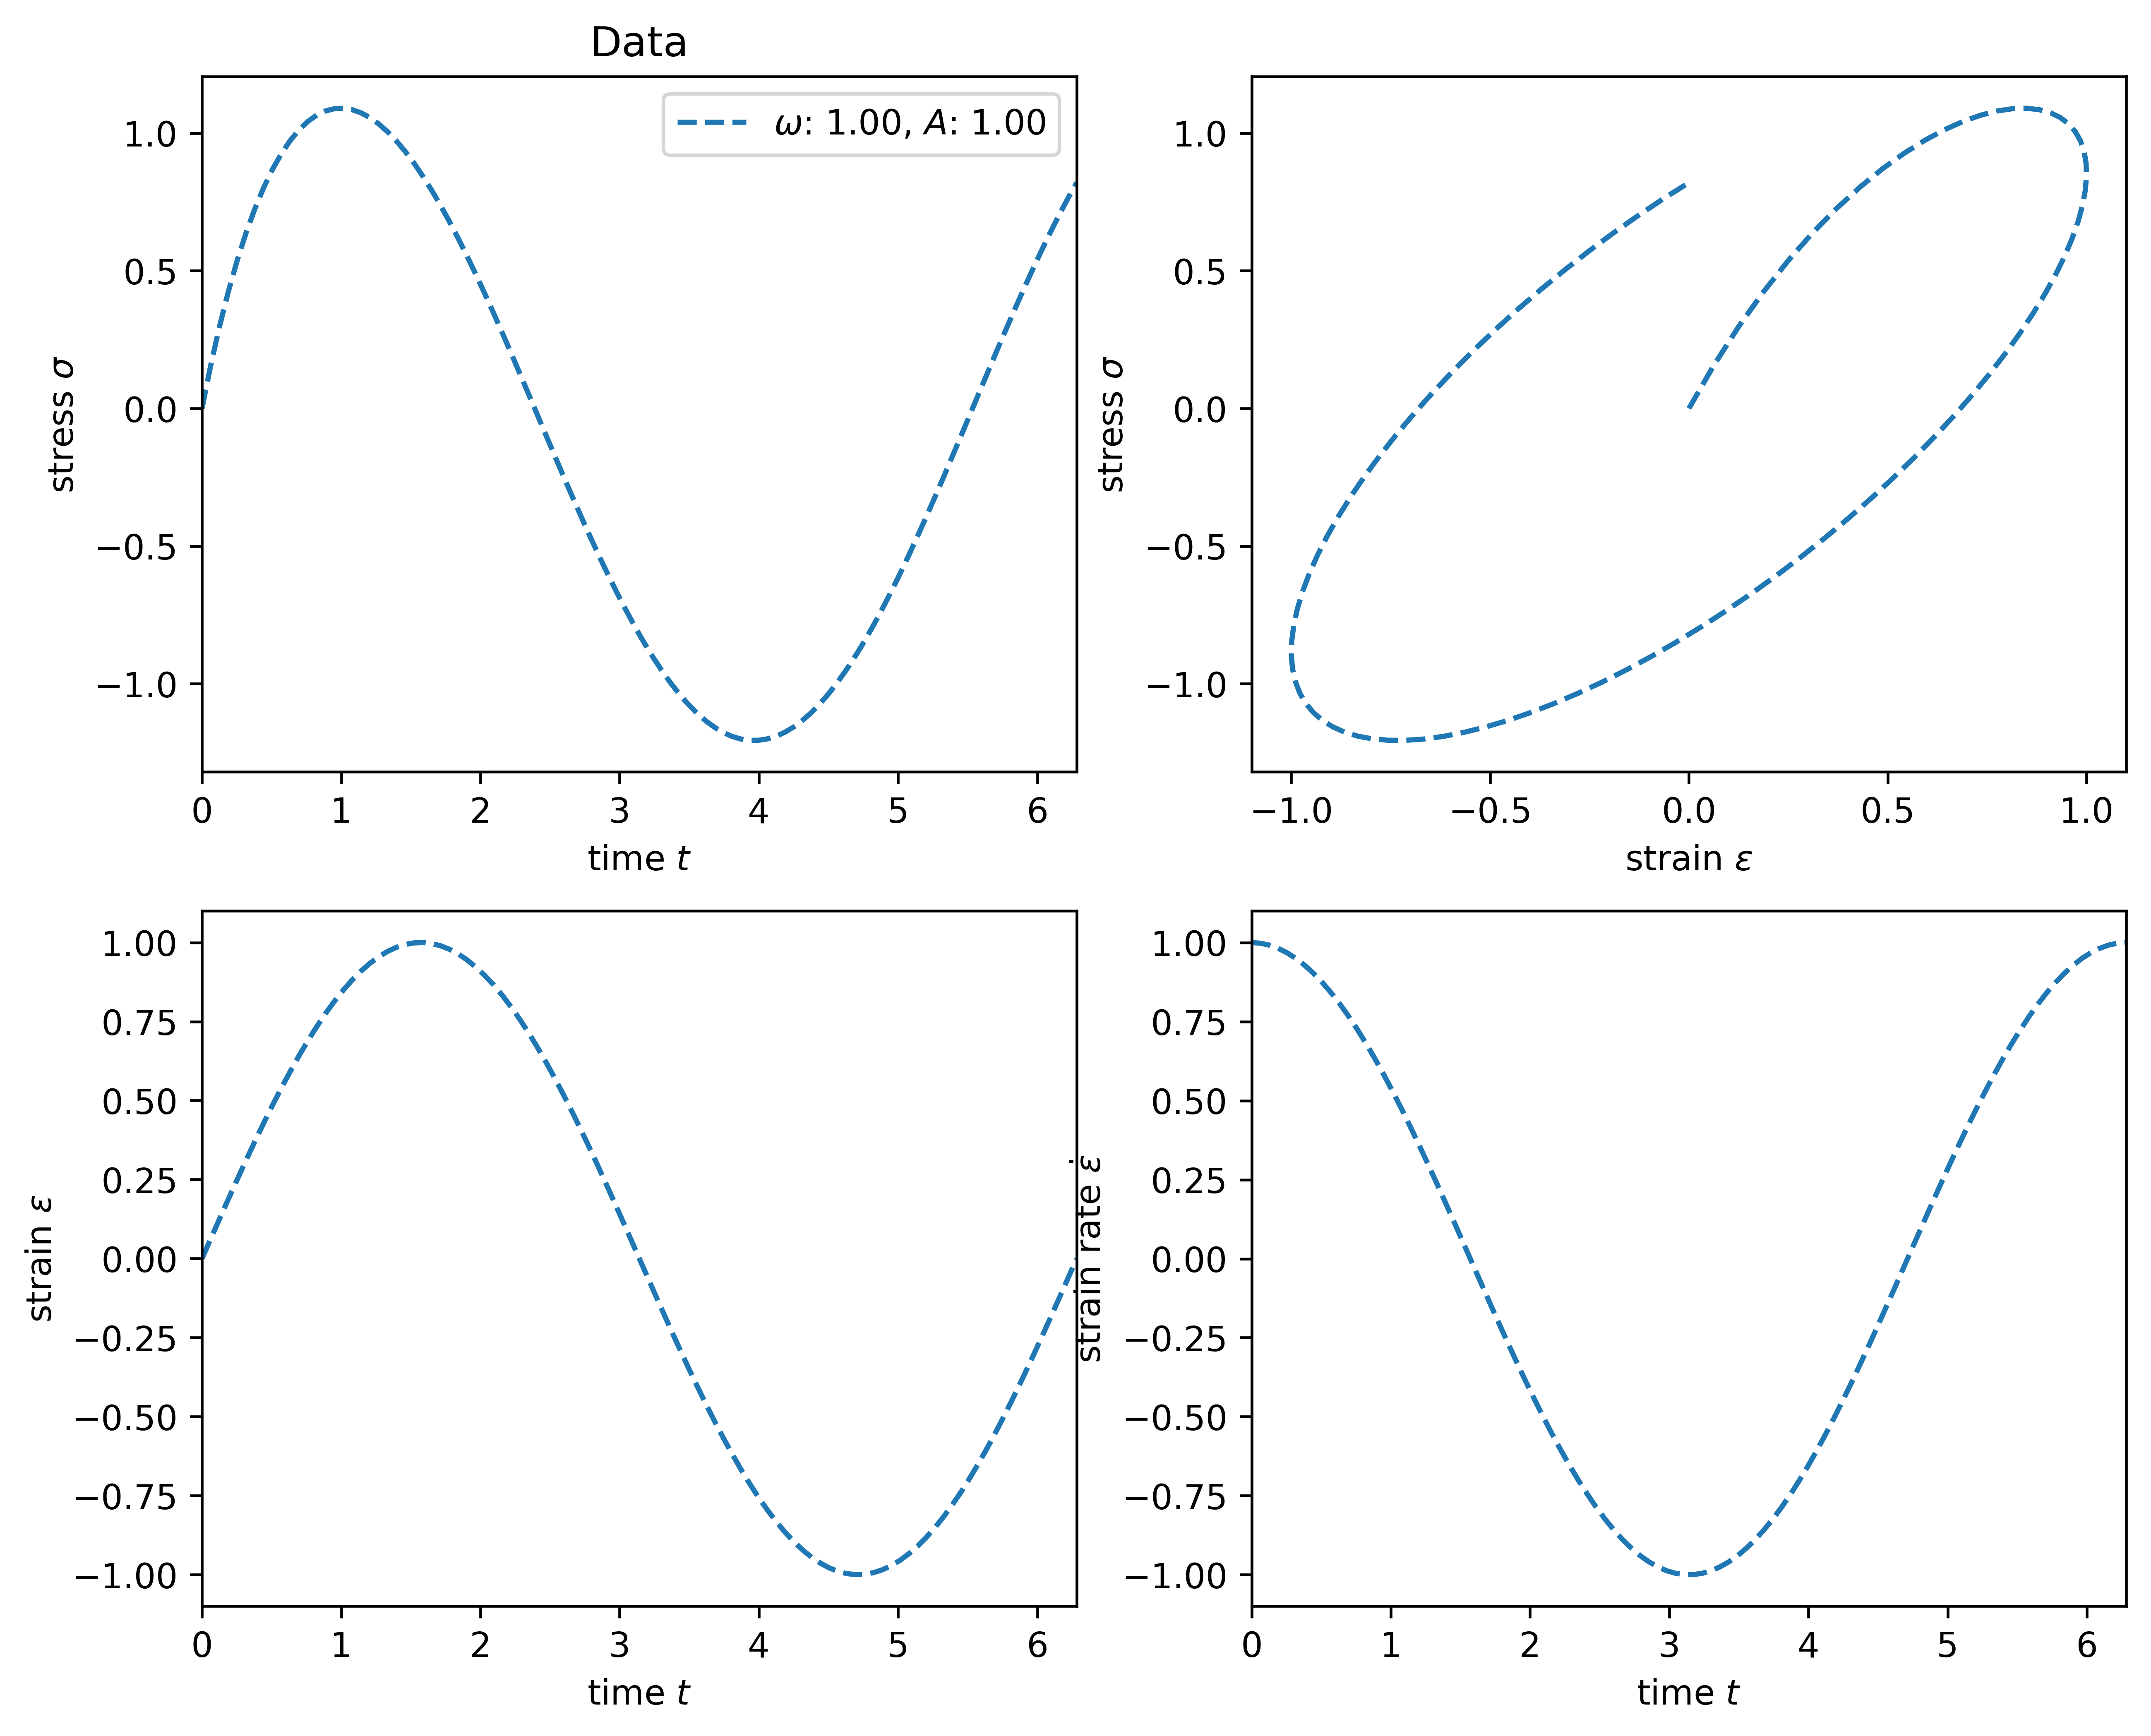

In [2]:
# model parameters
E_infty = 0.5
E = 2
eta = 1
params = {
    'E_infty': E_infty,
    'E': E,
    'eta': eta
    }

# harmonic load cases
n = 100      # number of data points
omegas = [1] # frequencies
As = [1]     # amplitudes

eps, eps_dot, sig, dt = d.generate_data_harmonic(E_infty, E, eta, n, omegas, As)
p.plot_data(eps, eps_dot, sig, omegas, As)

### 3.2 Relaxation data

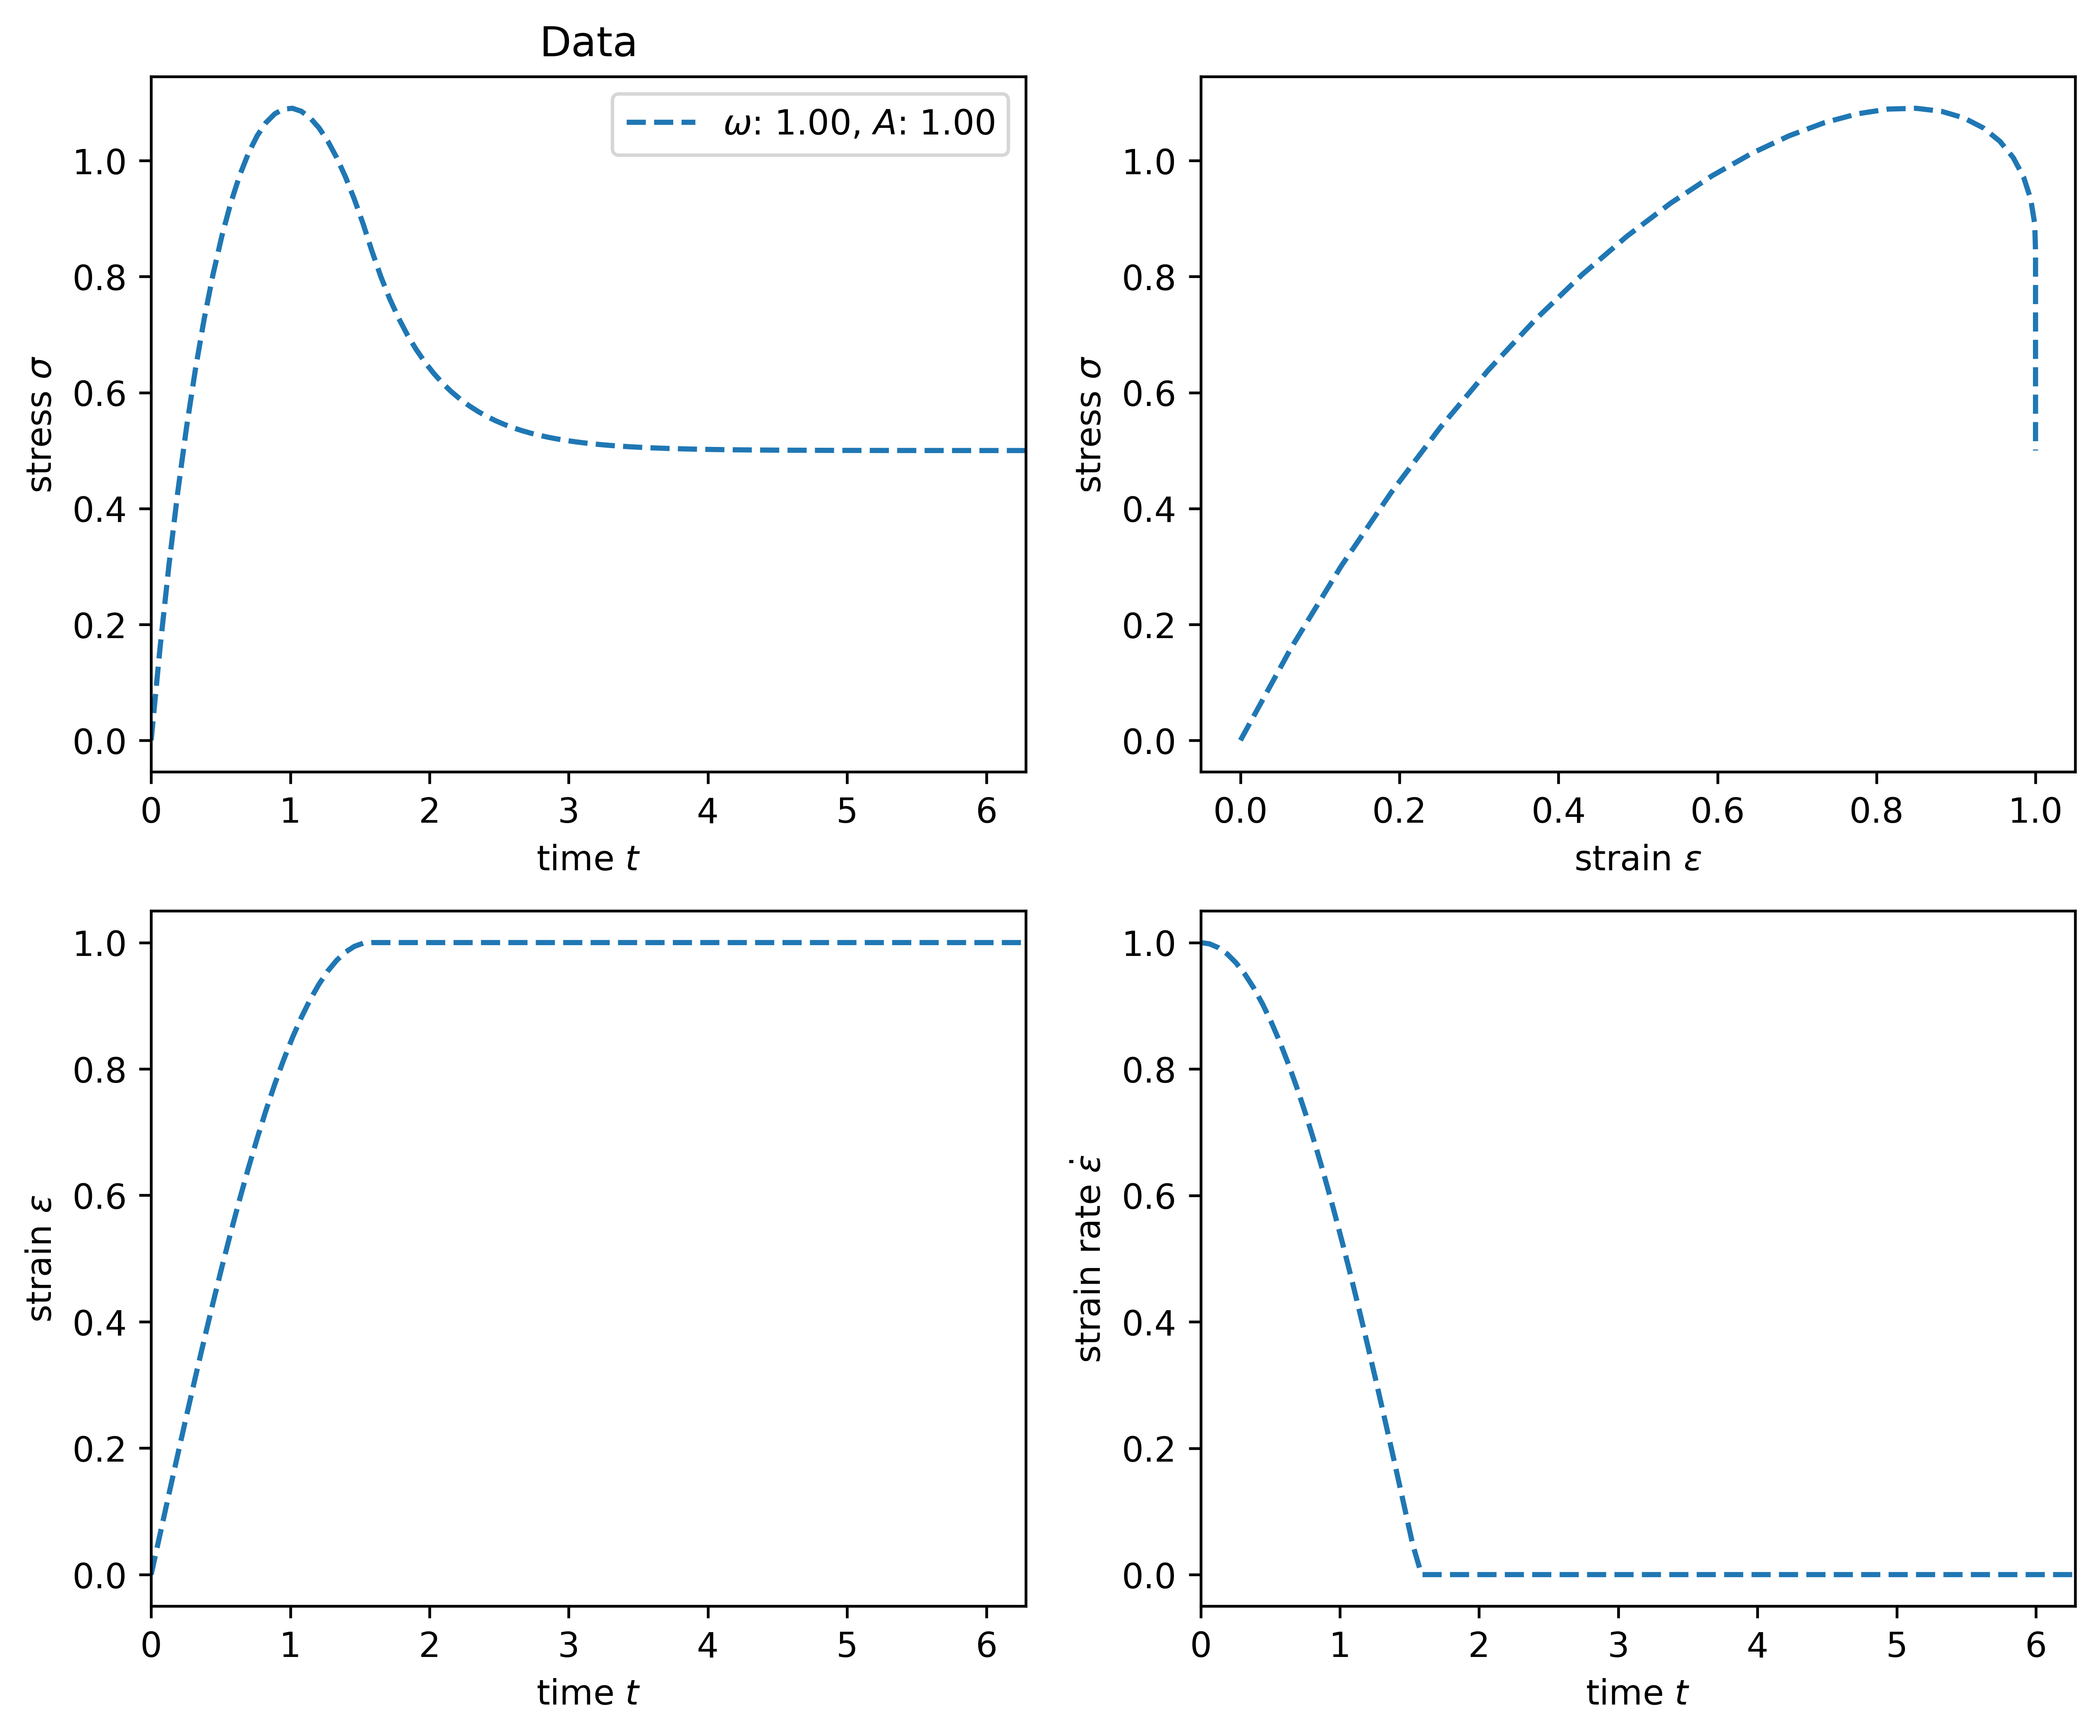

In [3]:
omegas = [1] # frequencies
As = [1]     # amplitudes

eps, eps_dot, sig, dt = d.generate_data_relaxation(E_infty, E, eta, n, omegas, As)
p.plot_data(eps, eps_dot, sig, omegas, As)

## 4. Load calibration and test data

In [4]:
# harmonic calibration data
omegas_c = [1] # frequencies
As_c = [1]     # amplitudes
eps_c, eps_dot_c, sig_c, dt_c = d.generate_data_harmonic(E_infty, E, eta, n, omegas_c, As_c)

# harmonic test data
omegas_t1 = [1, 1.5, 2]
As_t1 = [1, 2, 3]
eps_t1, eps_dot_t1, sig_t1, dt_t1 = d.generate_data_harmonic(E_infty, E, eta, n, omegas_t1, As_t1)

# relaxation test data
omegas_t2 = [1, 1.5, 2]
As_t2 = [1, 2, 3]
eps_t2, eps_dot_t2, sig_t2, dt_t2 = d.generate_data_relaxation(E_infty, E, eta, n, omegas_t2, As_t2)

## 5. Model building

In [5]:
# Available model options
# 'Maxwell analytical' - Analytical Maxwell model
# 'Naive' - Naive FFNN-based RNN model
# 'GSM' - Generalized standard material
m_type = 'Maxwell'

# Recommended architectures
# 'Maxwell analytical': none, none, none
# 'Naive': 32-2, softplus-linear, False-False
# 'GSM': 32-32-1, softplus-softplus-linear, False-False-False
model = m.build(
    m_type,
    params,
    units=[16, 1],
    activation=['softplus', 'linear'],
    non_neg=[False, True]
)

## 6. Model calibration

Epoch 1/10000

1/1 - 1s - loss: 0.6391 - 693ms/epoch - 693ms/step
Epoch 2/10000
1/1 - 0s - loss: 0.6197 - 8ms/epoch - 8ms/step
Epoch 3/10000
1/1 - 0s - loss: 0.6191 - 8ms/epoch - 8ms/step
Epoch 4/10000
1/1 - 0s - loss: 0.6184 - 10ms/epoch - 10ms/step
Epoch 5/10000
1/1 - 0s - loss: 0.6178 - 9ms/epoch - 9ms/step
Epoch 6/10000
1/1 - 0s - loss: 0.6172 - 8ms/epoch - 8ms/step
Epoch 7/10000
1/1 - 0s - loss: 0.6166 - 10ms/epoch - 10ms/step
Epoch 8/10000
1/1 - 0s - loss: 0.6160 - 9ms/epoch - 9ms/step
Epoch 9/10000
1/1 - 0s - loss: 0.6154 - 9ms/epoch - 9ms/step
Epoch 10/10000
1/1 - 0s - loss: 0.6148 - 8ms/epoch - 8ms/step
Epoch 11/10000
1/1 - 0s - loss: 0.6142 - 9ms/epoch - 9ms/step
Epoch 12/10000
1/1 - 0s - loss: 0.6137 - 9ms/epoch - 9ms/step
Epoch 13/10000
1/1 - 0s - loss: 0.6131 - 8ms/epoch - 8ms/step
Epoch 14/10000
1/1 - 0s - loss: 0.6126 - 10ms/epoch - 10ms/step
Epoch 15/10000
1/1 - 0s - loss: 0.6120 - 10ms/epoch - 10ms/step
Epoch 16/10000
1/1 - 0s - loss: 0.6115 - 9ms/epoch - 9ms/step
Epoc

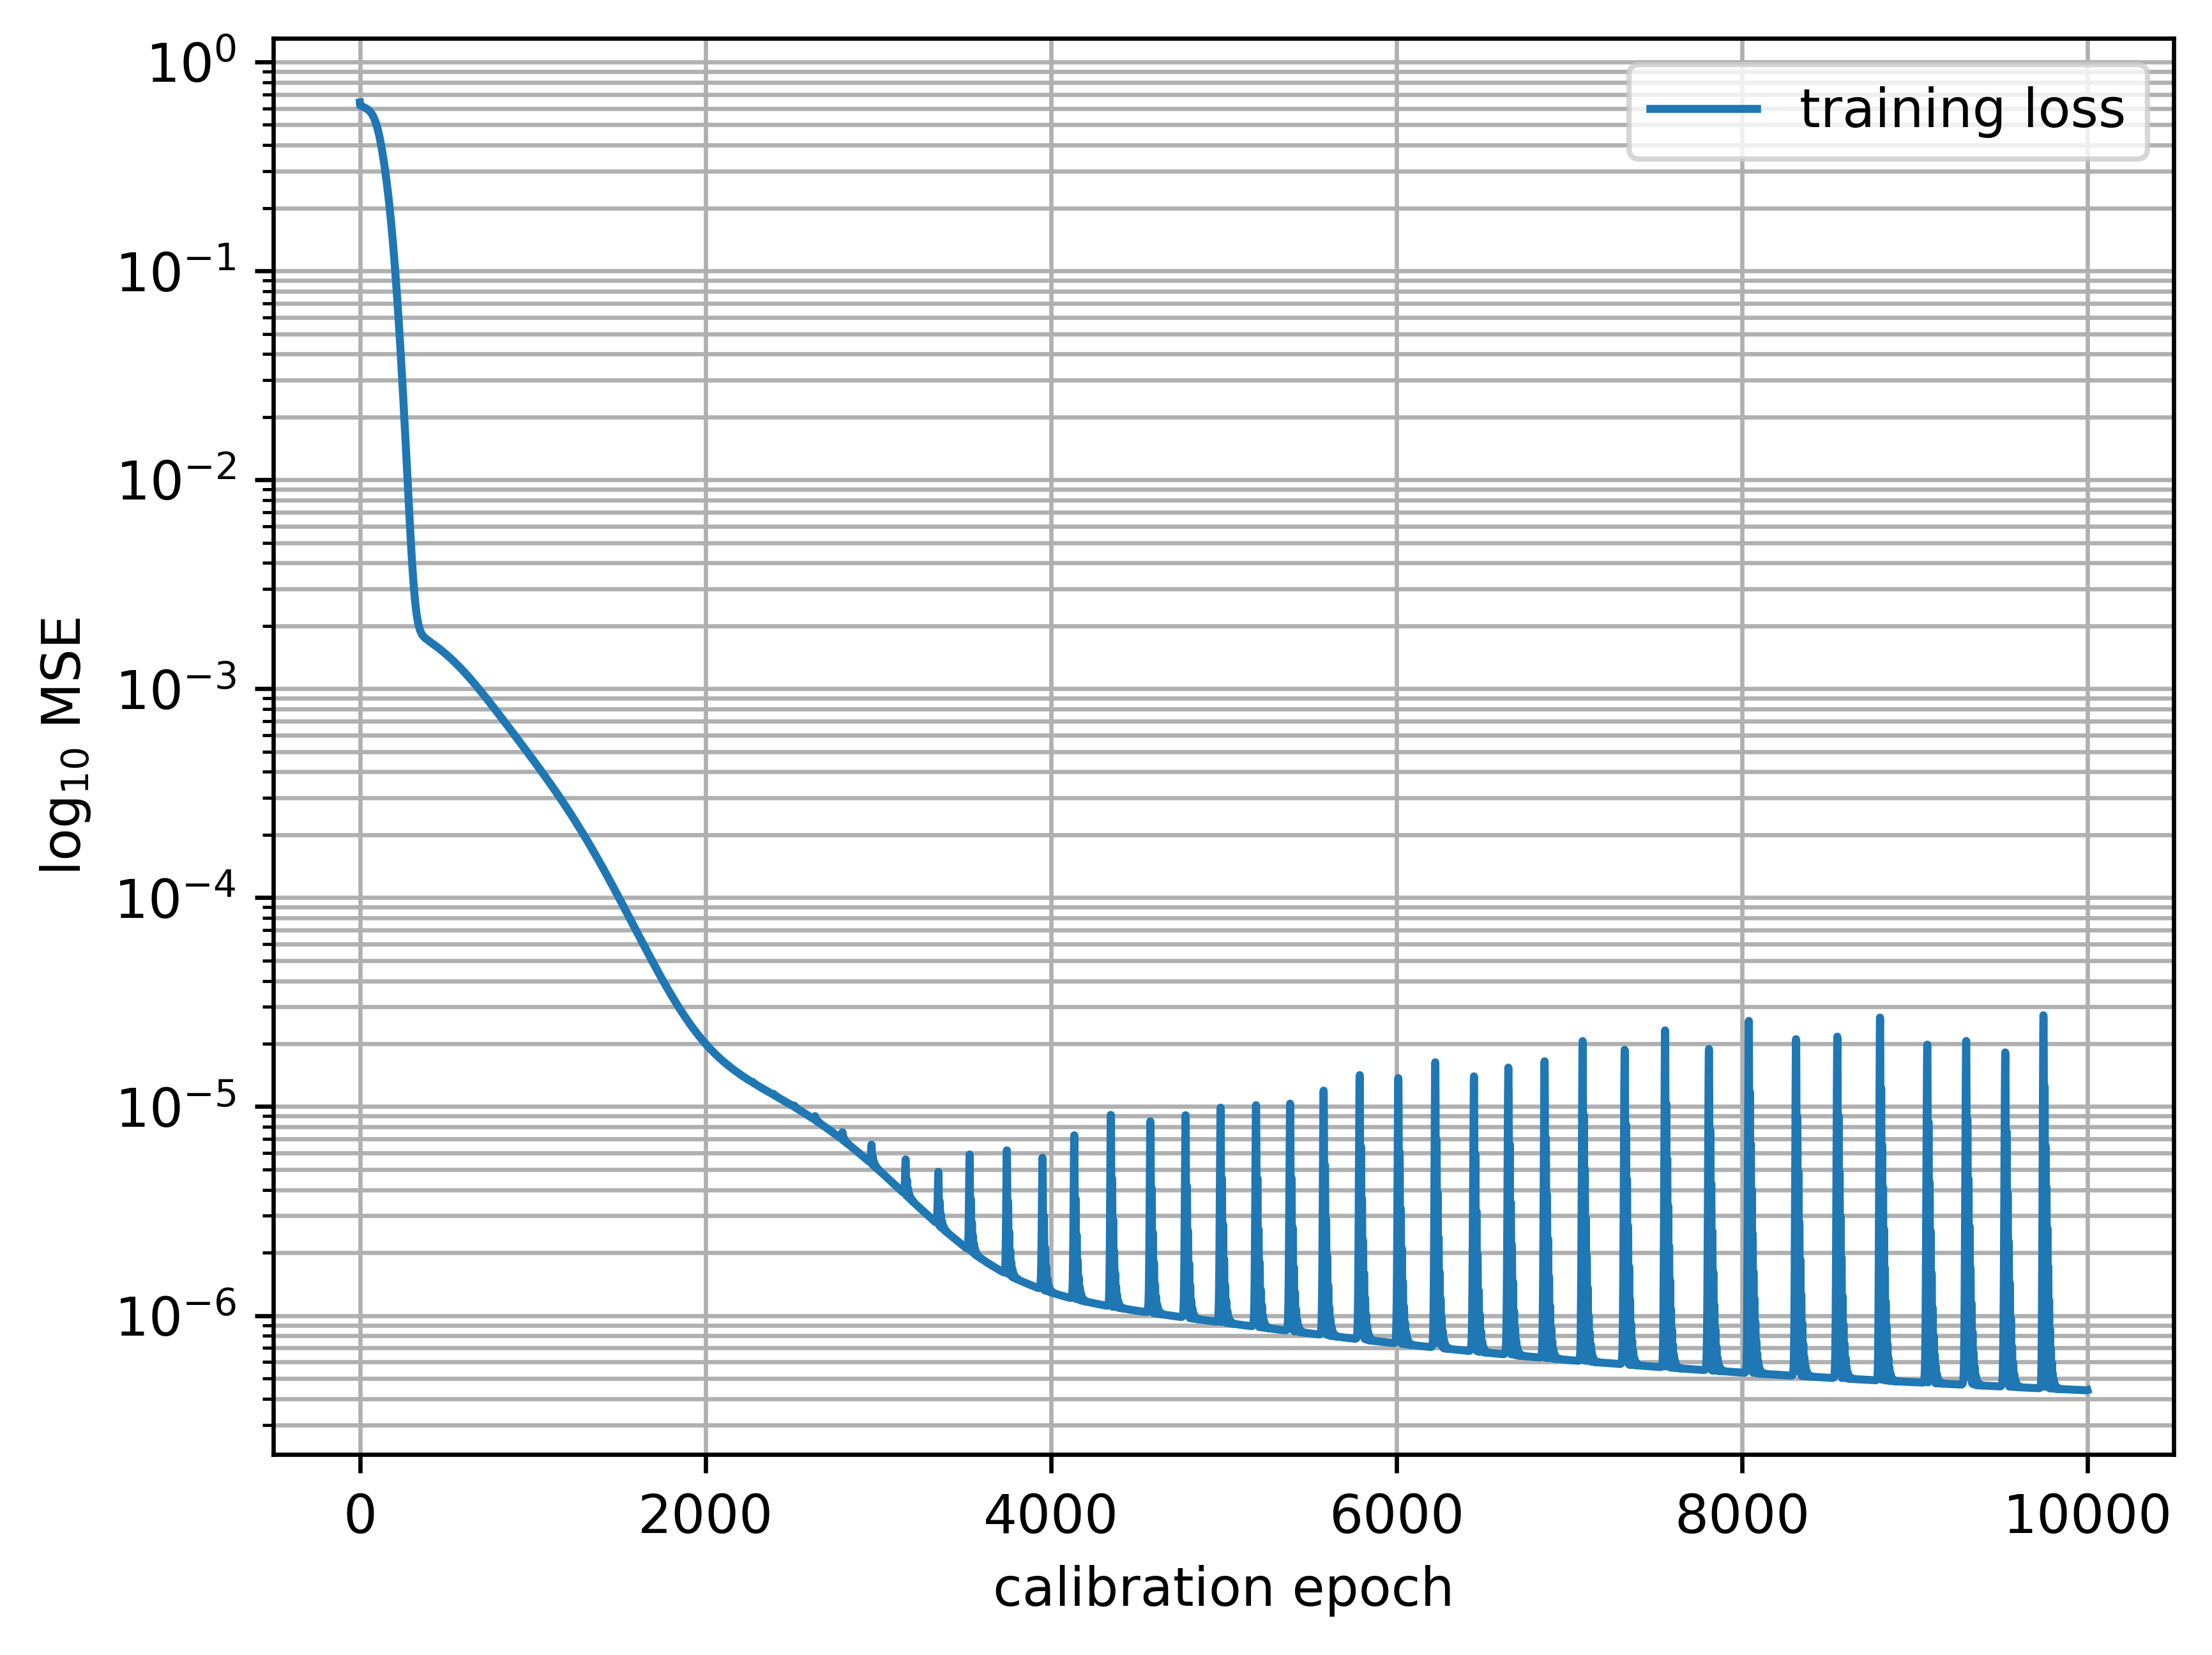

In [6]:
# training epochs
NEPOCHS = 10000

t1 = now()
model.optimizer.learning_rate.assign(0.002)
h = model.fit([eps_c, dt_c], [sig_c], 
            epochs=NEPOCHS,  
            verbose=2)
t2 = now()
print('it took', t2 - t1, '(sec) to calibrate the model')
p.plot_loss(h.history)

## 7. Evaluation

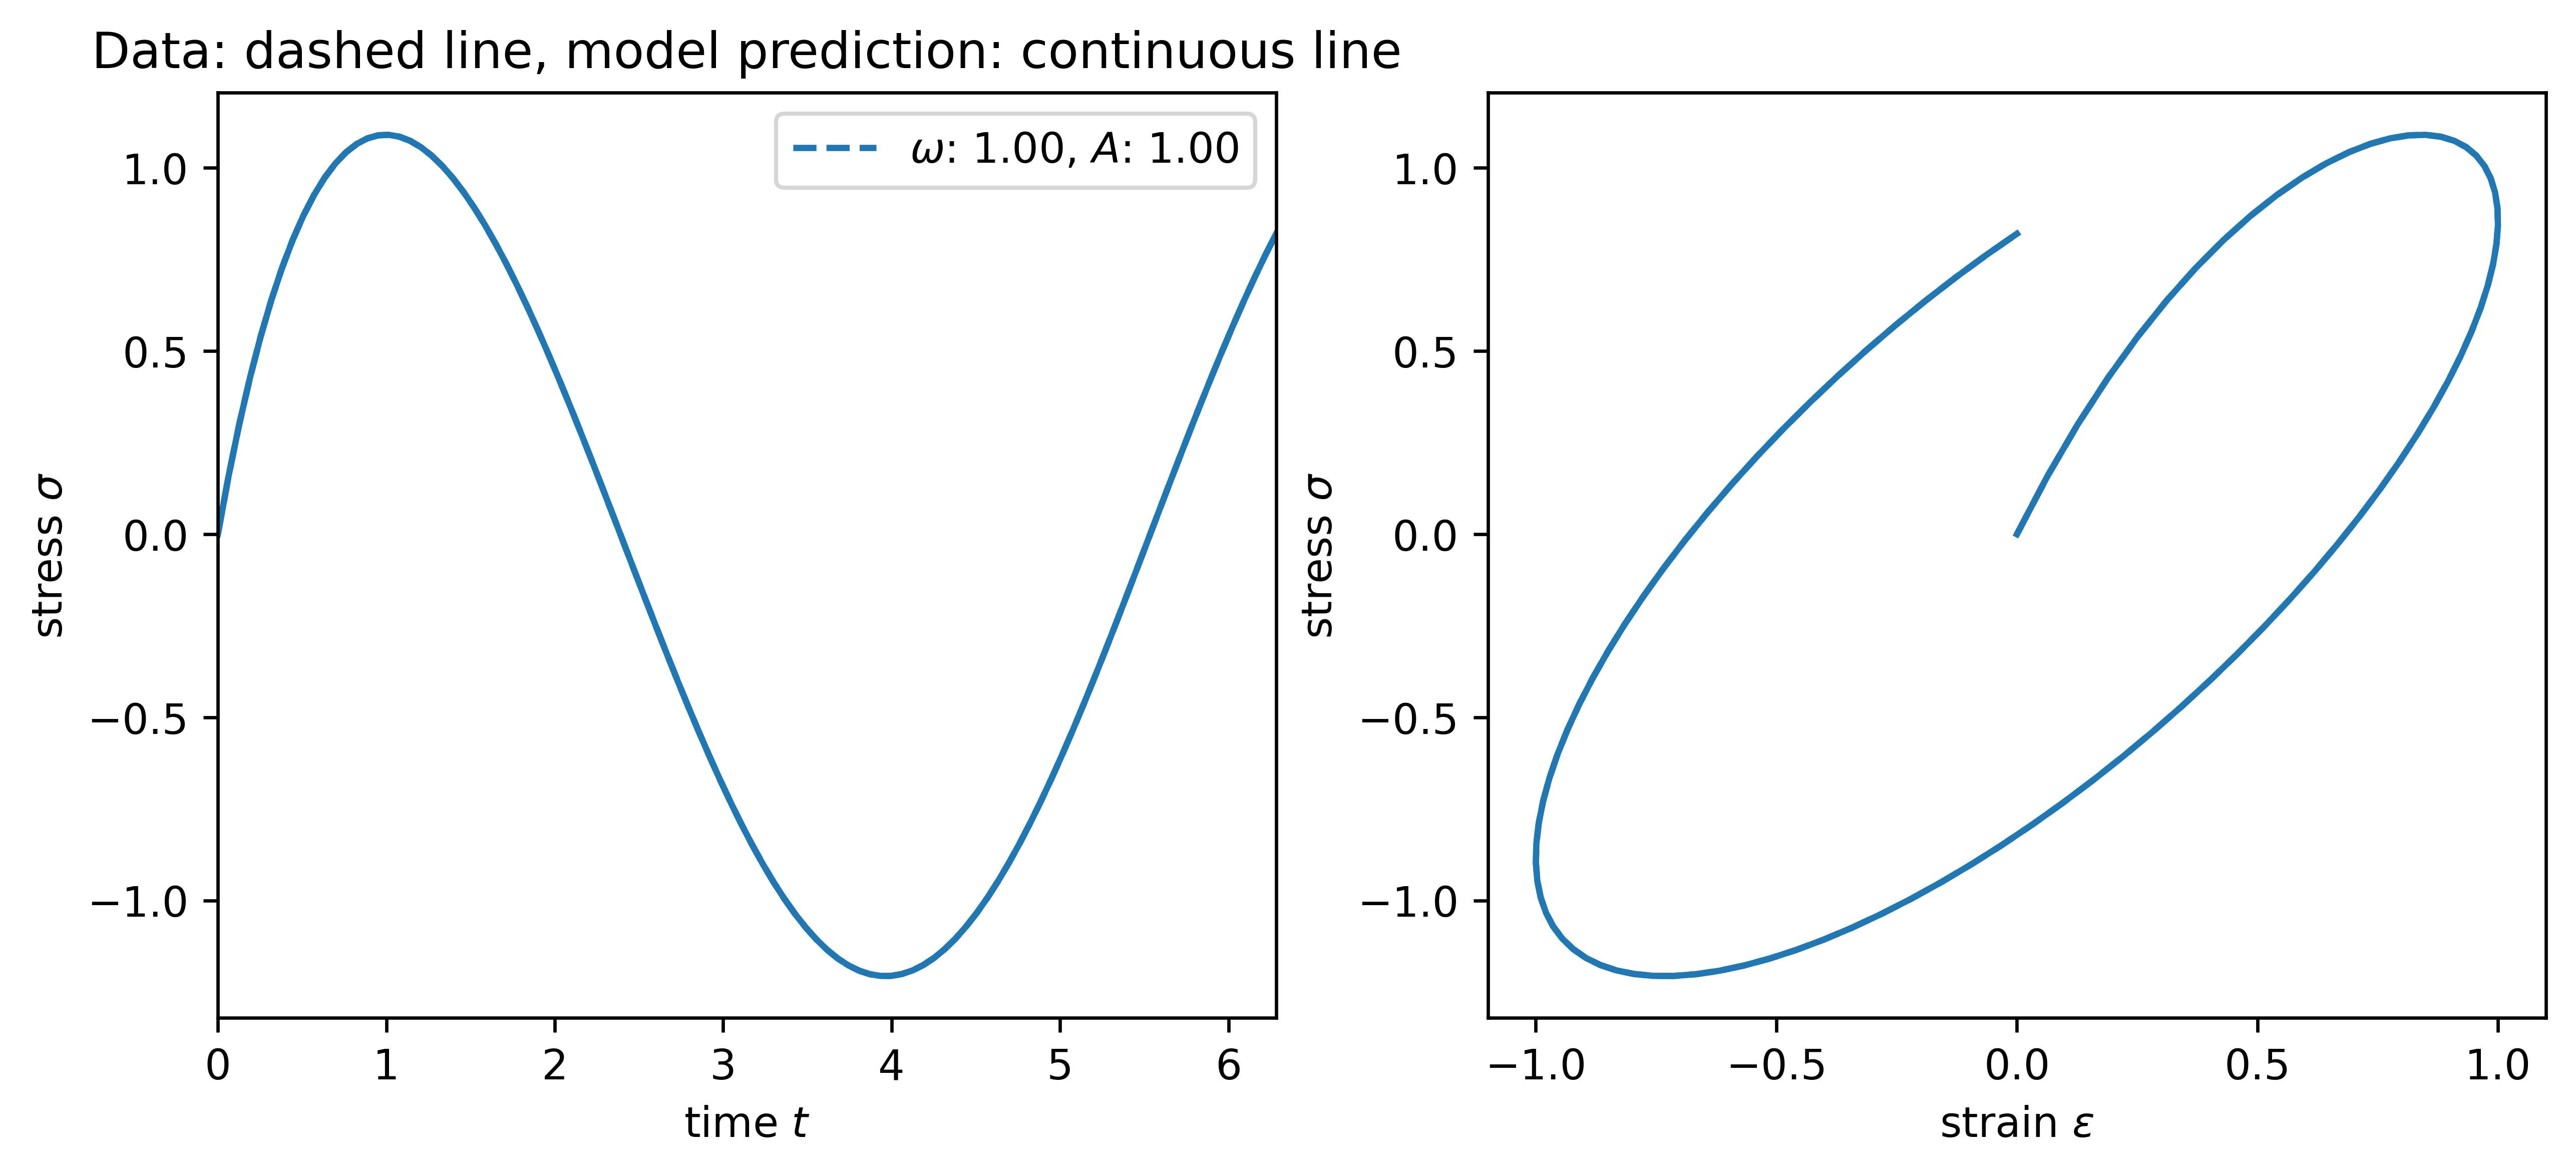

In [6]:
# evaluation on calibration data
sig_pred = model([eps_c, dt_c])
p.plot_model_pred(eps_c, sig_c, sig_pred, omegas_c, As_c)

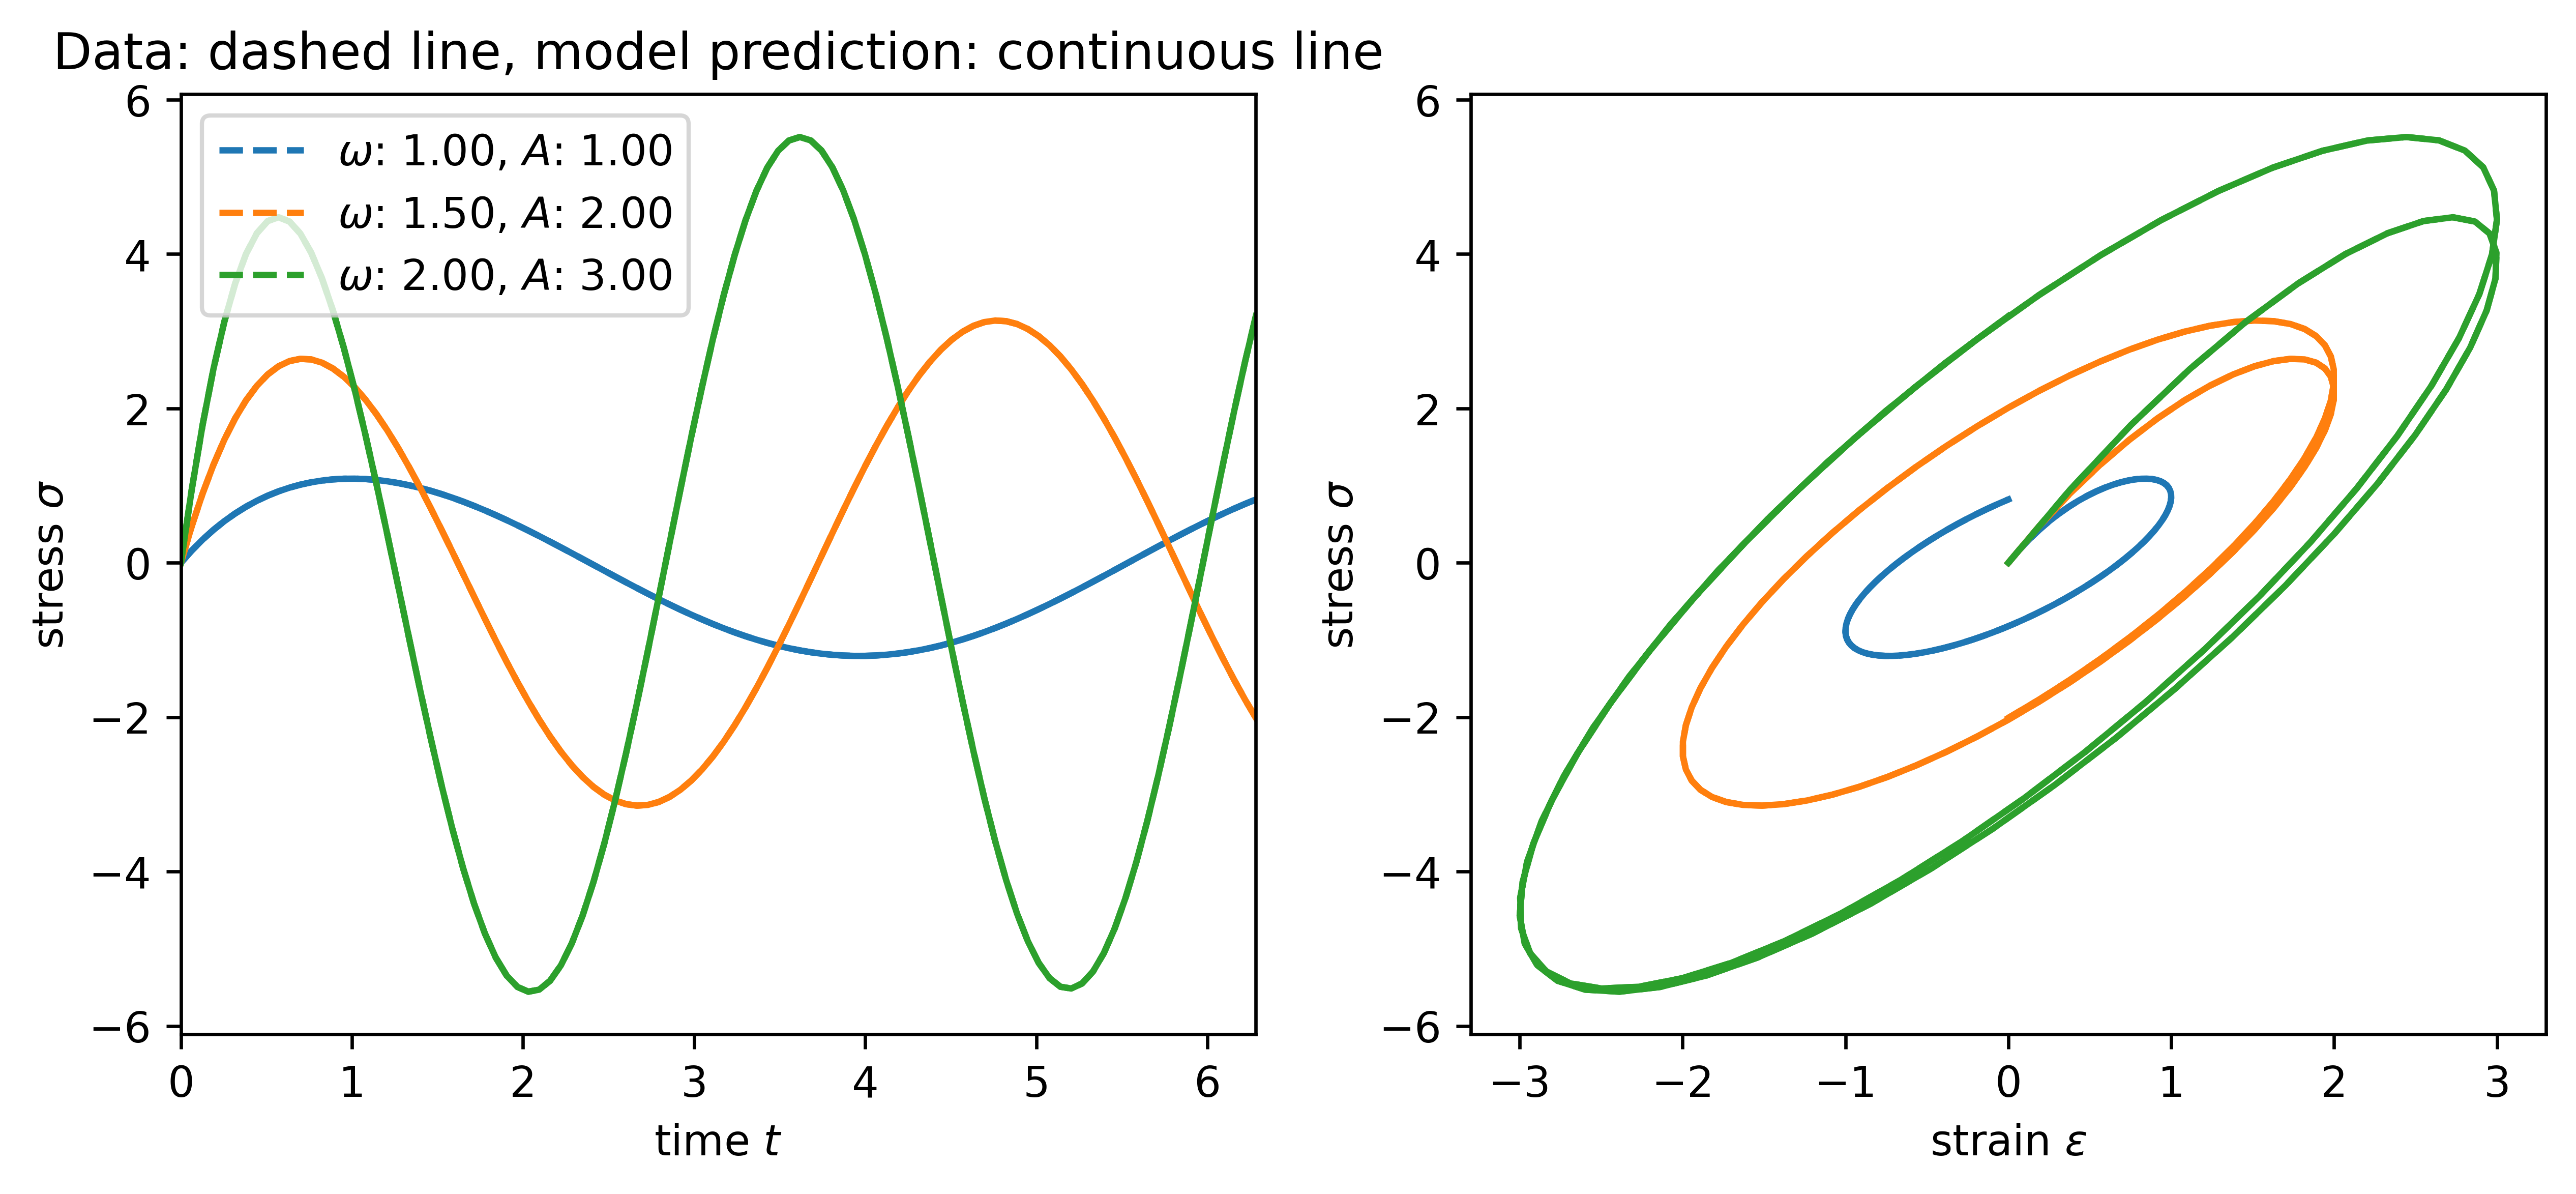

In [7]:
# evaluation on harmonic data
sig_pred = model([eps_t1, dt_t1])
p.plot_model_pred(eps_t1, sig_t1, sig_pred, omegas_t1, As_t1)

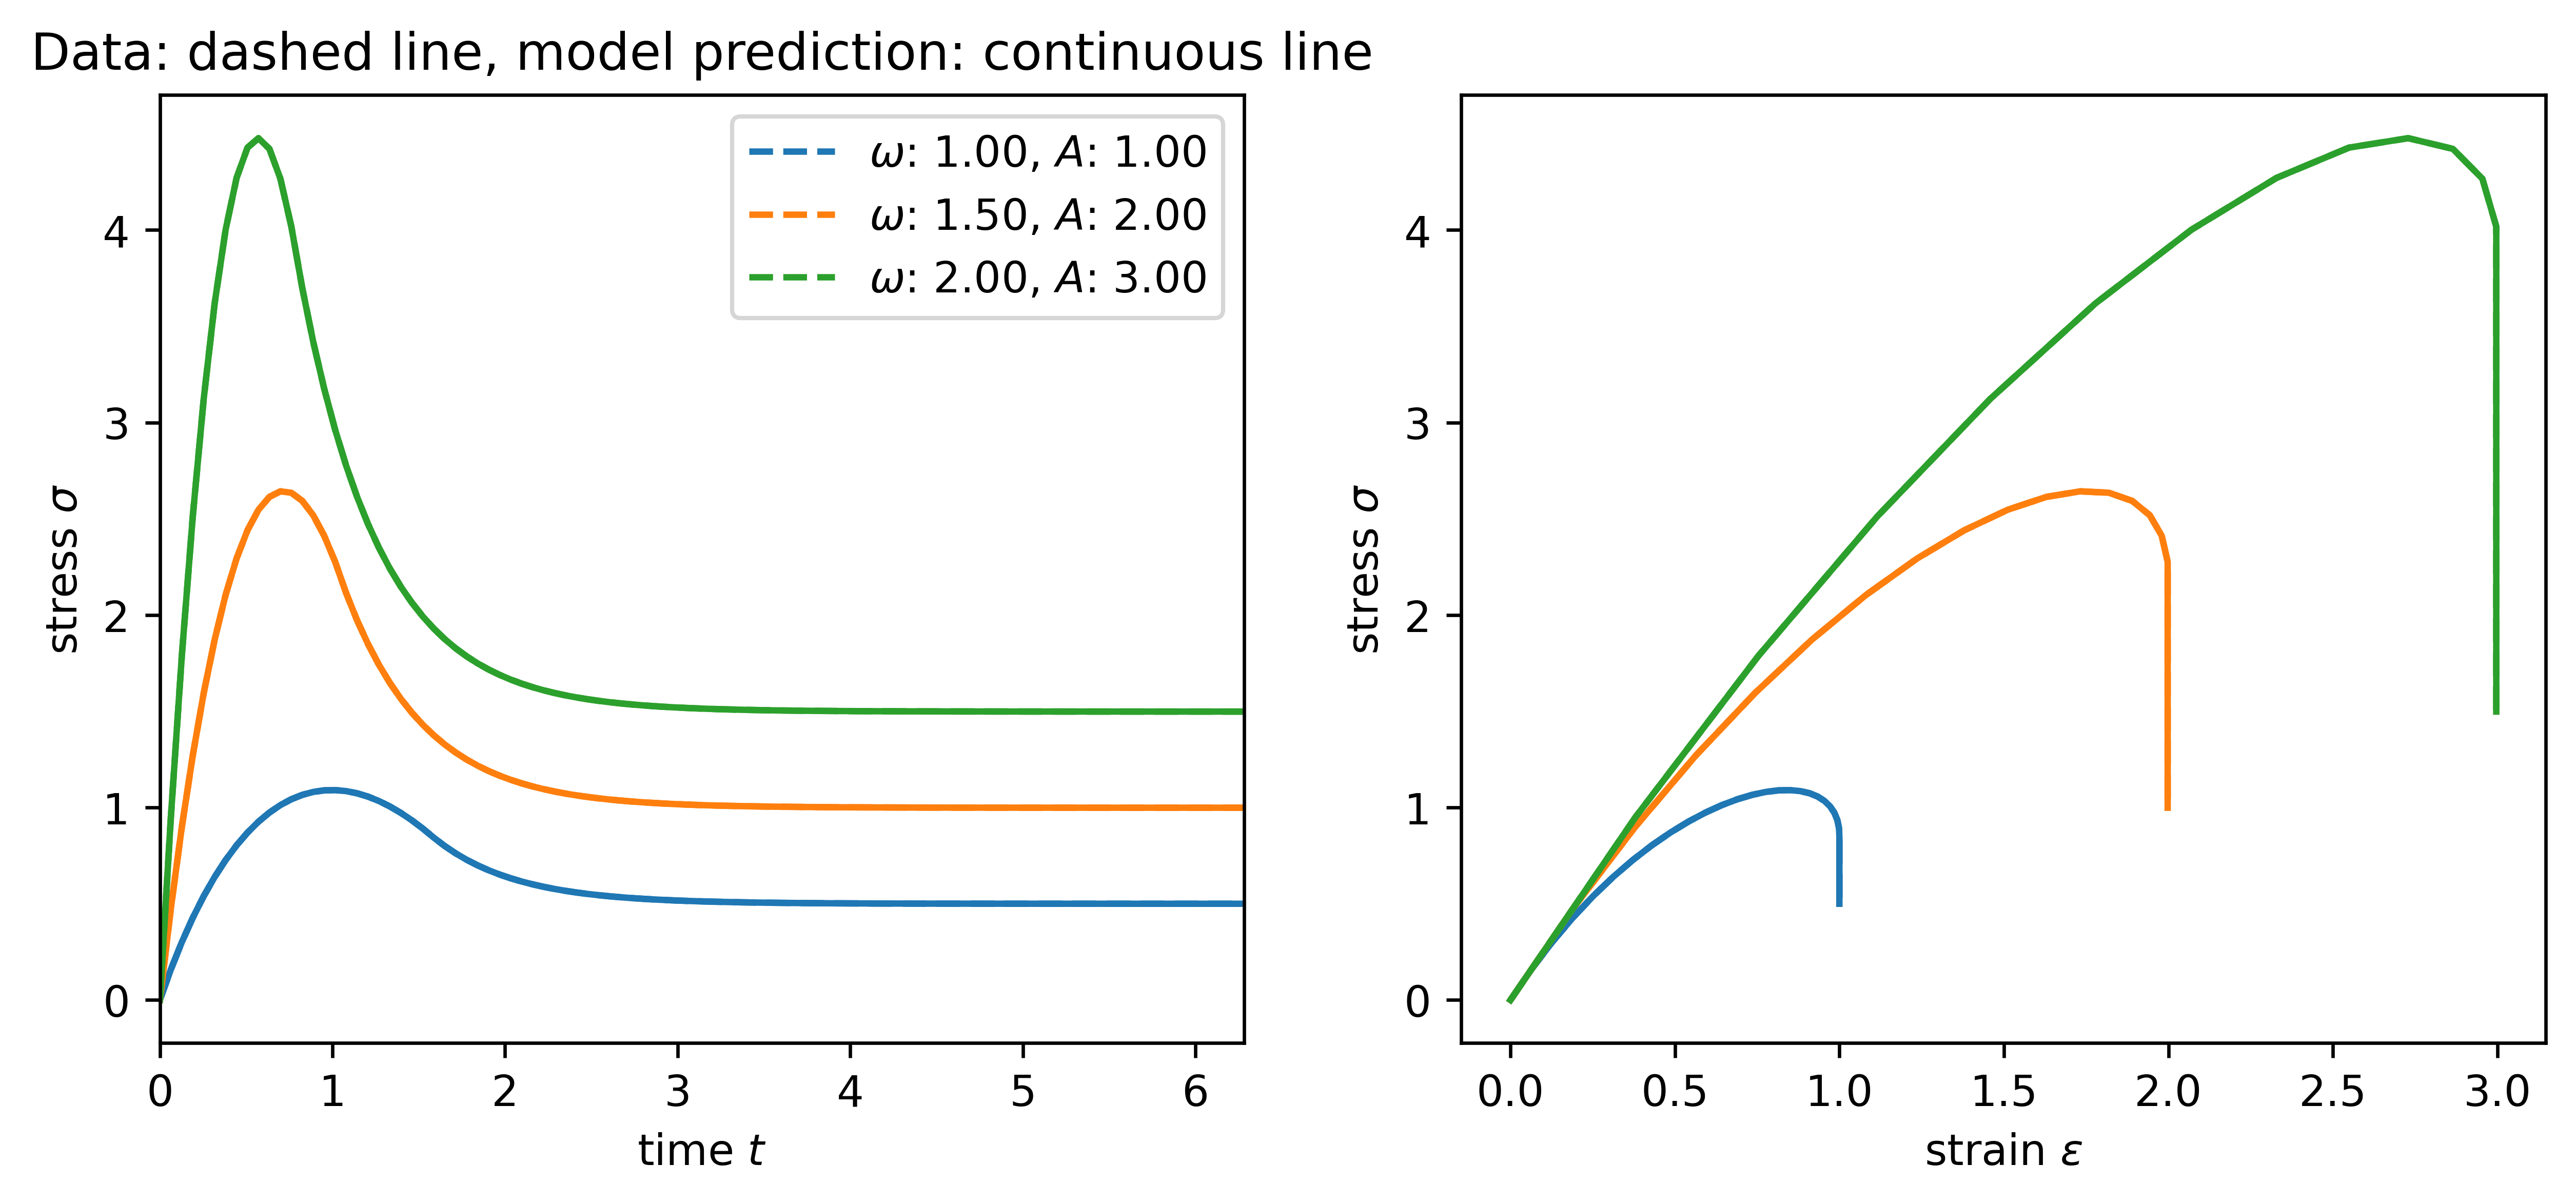

In [8]:
# evaluation on relaxation data
sig_pred = model([eps_t2, dt_t2])
p.plot_model_pred(eps_t2, sig_t2, sig_pred, omegas_t2, As_t2)